In [1]:
# Fix randomness and hide warnings
seed = 42
%load_ext autoreload
%autoreload 2

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

import matplotlib.pyplot as plt
plt.rc('font', size=16)

from C2.notebooks.Utils import split_dataset, build_sequences_optimized
from C2.notebooks.data_augmentation import augment_data

2.15.0


In [2]:
input_folder = '../data/training_dataset/'
training_data = np.load(input_folder + 'training_data.npy')
valid_periods = np.load(input_folder + 'valid_periods.npy')
categories = np.load(input_folder + 'categories.npy')

In [3]:

dataset, labels = build_sequences_optimized(training_data, valid_periods)
train_validation_data, train_validation_labels, test_data, test_labels = split_dataset(dataset, labels)
train_data, train_labels, validation_data, validation_labels = split_dataset(train_validation_data, train_validation_labels, augment_train_data=True, num_augmentations=3)

train_data = train_data.reshape((train_data.shape[0], train_data.shape[1], 1))
train_labels = train_labels.reshape((train_labels.shape[0], train_labels.shape[1], 1))
# validation_data = validation_data.reshape((validation_data.shape[0], validation_data.shape[1], 1))
# validation_labels = validation_labels.reshape((validation_labels.shape[0], validation_labels.shape[1], 1))
# test_data = test_data.reshape((test_data.shape[0], test_data.shape[1], 1))
# test_labels = test_labels.reshape((test_labels.shape[0], test_labels.shape[1], 1))
train_data.shape

Dataset shape:  (48000, 200)
Train data shape:  (38400, 200)
Test data shape:  (9600, 200)
Augmenting training data
Augmentation round: 0
Augmentation round: 1
Augmentation round: 2
Train data shape:  (276480, 200)
Test data shape:  (7680, 200)


(276480, 200, 1)

In [4]:
# def build_LSTM_ENC_DEC_model_params(input_shape, output_shape, learning_rate=0.001, num_layers=2, num_units_lstm=32, num_units_final_dense = 128, dropout=0.2):
#     assert input_shape[0] >= output_shape[0], "Input time steps should be >= output time steps"
# 
#     # Input layer
#     input_layer = tf.keras.layers.Input(shape=input_shape, name='input_layer')
#     # input_category = tf.keras.layers.Input(shape=(1,), name='input_category')
#     # subtract last input value of the input sequence to all the input sequence, do like input_layer - constant, where constant is the last value of the input_layer
#     
#     last_seq = tf.keras.layers.Lambda(lambda x: x[:, -1:, :])(input_layer)
#     x = input_layer - last_seq
#     
#     
#     # LSTM layers
#     for _ in range(num_layers):
#         x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(int(num_units_lstm/4), name='lstm', return_sequences=True))(x)
#         x = tf.keras.layers.Dropout(dropout)(x)
#         
#     conv = tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
#     conv = tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(conv)
#     conv = tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(conv)
#     flatten_conv = tf.keras.layers.Flatten()(conv)
#     
#     conv_input = tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(input_layer)
#     conv_input_2 = tf.keras.layers.Conv1D(filters=32, kernel_size=10, padding='same', activation='relu')(input_layer)
#     concat_conv = tf.keras.layers.Concatenate()([conv_input, conv_input_2])
#     flatten_conv_input = tf.keras.layers.Flatten()(concat_conv)
#     dense_conv = tf.keras.layers.Dense(32, activation='relu')(flatten_conv_input)
#     
#     
#     x = tf.keras.layers.Flatten()(x)
#     flatten_input = tf.keras.layers.Flatten()(input_layer)
#     # Skipper layer
#     x = tf.keras.layers.Concatenate()([x, flatten_input, flatten_conv, dense_conv])
#     x = tf.keras.layers.Dense(num_units_final_dense, activation='relu')(x)
#     
#     # Output layer
#     output_layer = tf.keras.layers.Dense(output_shape[0], name='output_layer', activation='linear')(x)
#     
#     # sum last output last_seq to all the output sequence, do like output_layer + constant, where constant is the last value of the last_seq
#     
#     # https://arxiv.org/pdf/2308.11200v1.pdf
#     output_layer = output_layer +  tf.keras.layers.Reshape((1,))(last_seq)
#     
#    
#     # Model instantiation
#     model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer, name='Better_CONV_LSTM_model')
# 
#     # Compiling the model
#     model.compile(loss=tf.keras.losses.MeanAbsoluteError(),
#                   metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanSquaredError()],
#                   optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
# 
#     return model
def build_LSTM_ENC_DEC_model_params(input_shape, output_shape, learning_rate=0.001, num_layers=2, num_units_lstm=32, num_units_final_dense = 128, dropout=0.2):
    assert input_shape[0] >= output_shape[0], "Input time steps should be >= output time steps"

    # Input layer
    input_layer = tf.keras.layers.Input(shape=input_shape, name='input_layer')
    # input_category = tf.keras.layers.Input(shape=(1,), name='input_category')
    # subtract last input value of the input sequence to all the input sequence, do like input_layer - constant, where constant is the last value of the input_layer
    
    last_seq = tf.keras.layers.Lambda(lambda x: x[:, -1:, :])(input_layer)
    x = input_layer - last_seq
    
    
    
        
    conv = tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    conv = tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(conv)
    conv = tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(conv)
    x = conv
    
    # LSTM layers
    for _ in range(num_layers):
        x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(int(num_units_lstm/4), name='lstm', return_sequences=True))(x)
        x = tf.keras.layers.Dropout(dropout)(x)
        
    x = tf.keras.layers.Flatten()(x)
    flatten_input = tf.keras.layers.Flatten()(input_layer)
    # Skipper layer
    x = tf.keras.layers.Concatenate()([x, flatten_input])
    x = tf.keras.layers.Dense(num_units_final_dense, activation='relu')(x)
    
    # Output layer
    output_layer = tf.keras.layers.Dense(output_shape[0], name='output_layer', activation='linear')(x)
    
    # sum last output last_seq to all the output sequence, do like output_layer + constant, where constant is the last value of the last_seq
    
    # https://arxiv.org/pdf/2308.11200v1.pdf
    output_layer = output_layer +  tf.keras.layers.Reshape((1,))(last_seq)
    
   
    # Model instantiation
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer, name='Better_CONV_LSTM_model')

    # Compiling the model
    model.compile(loss=tf.keras.losses.MeanAbsoluteError(),
                  metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanSquaredError()],
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

    return model


In [ ]:
input_shape = train_data.shape[1:]
output_shape = train_labels.shape[1:]
batch_size = 256
epochs = 11

model = build_LSTM_ENC_DEC_model_params(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True) 

model.fit(
    x = train_validation_data,
    y = train_validation_labels,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(test_data, test_labels),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', min_delta=0.0001, patience=3, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=2, factor=0.1, min_lr=1e-5)
    ]
)

32/32 [==============================] - 0s 9ms/step


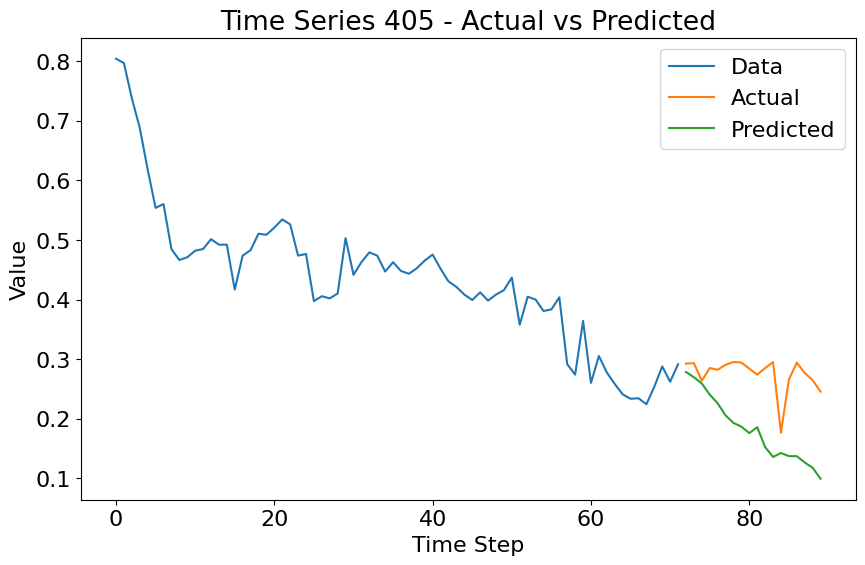

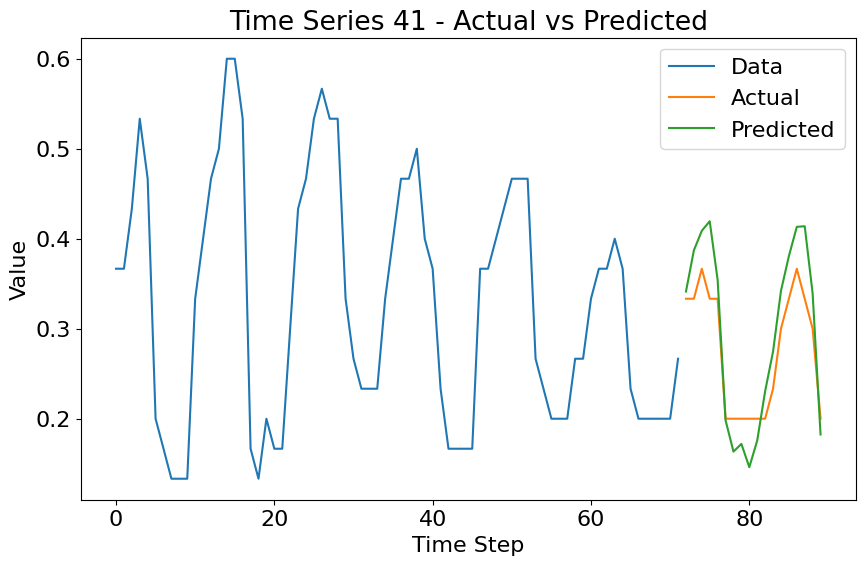

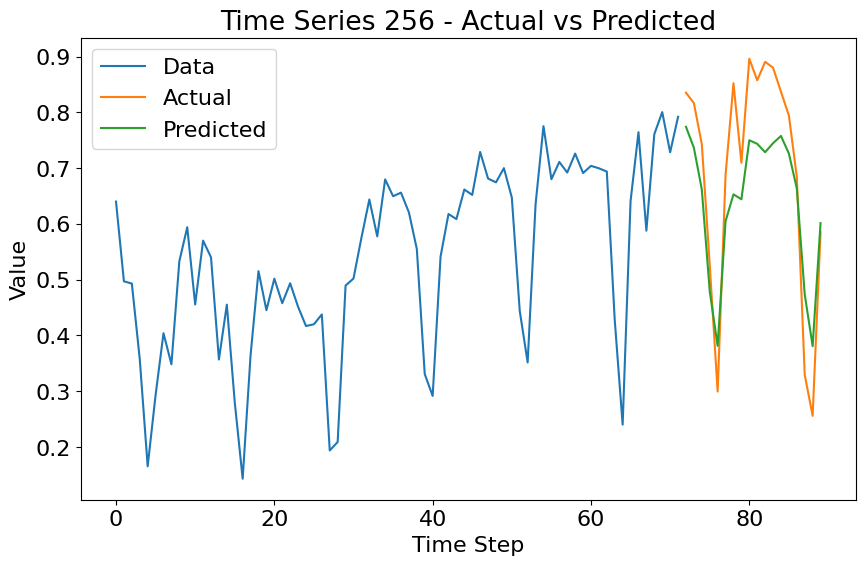

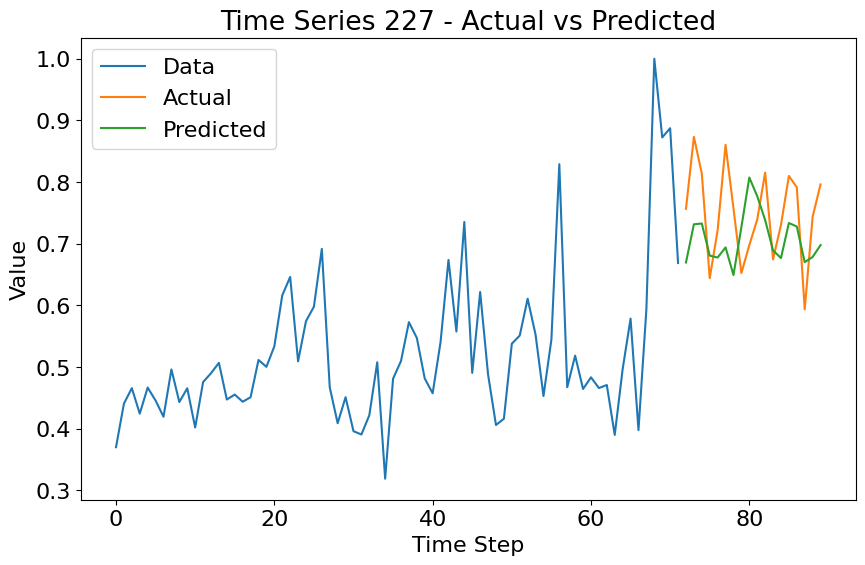

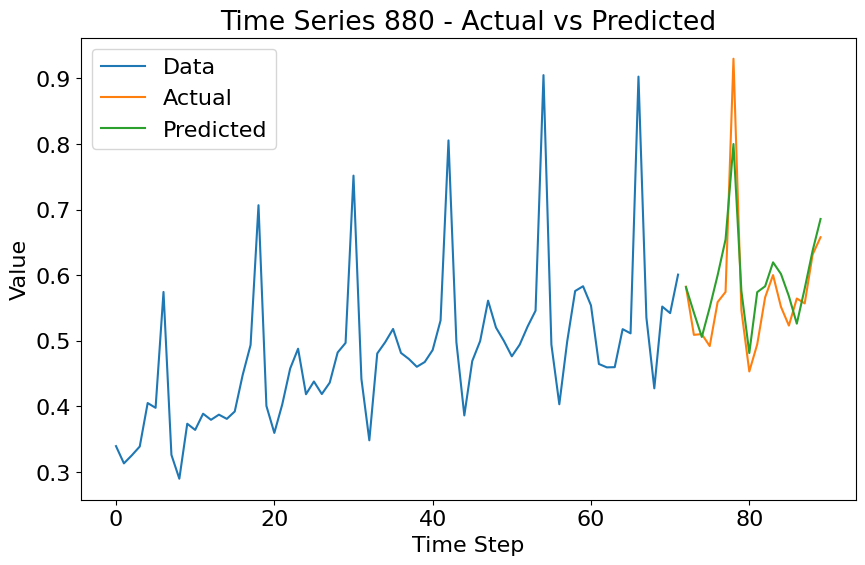

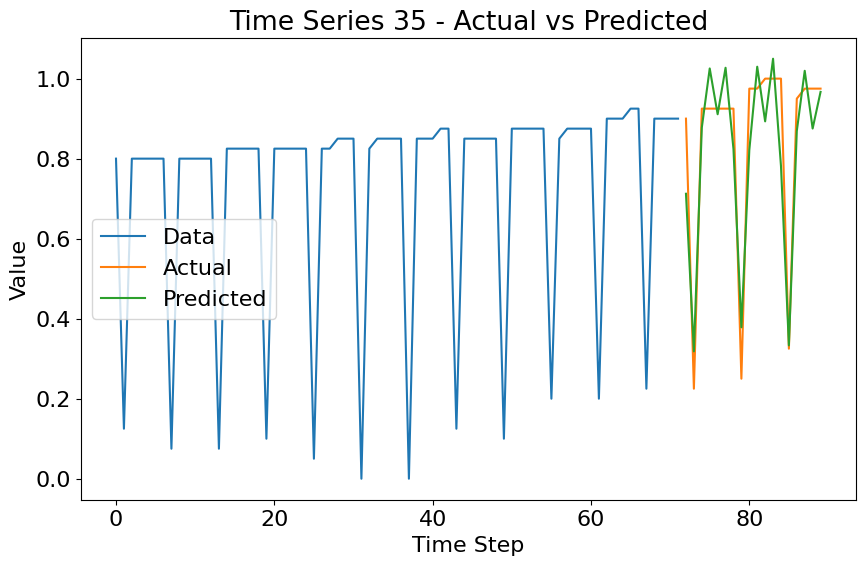

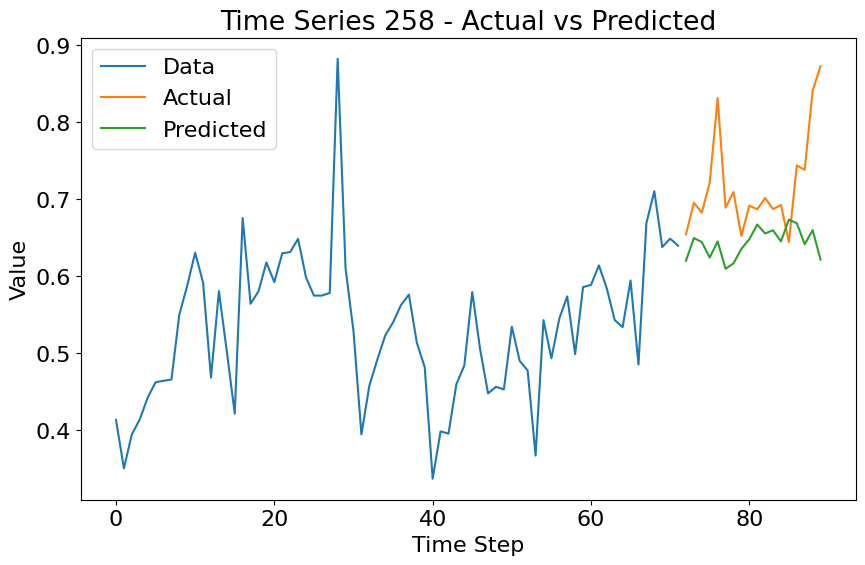

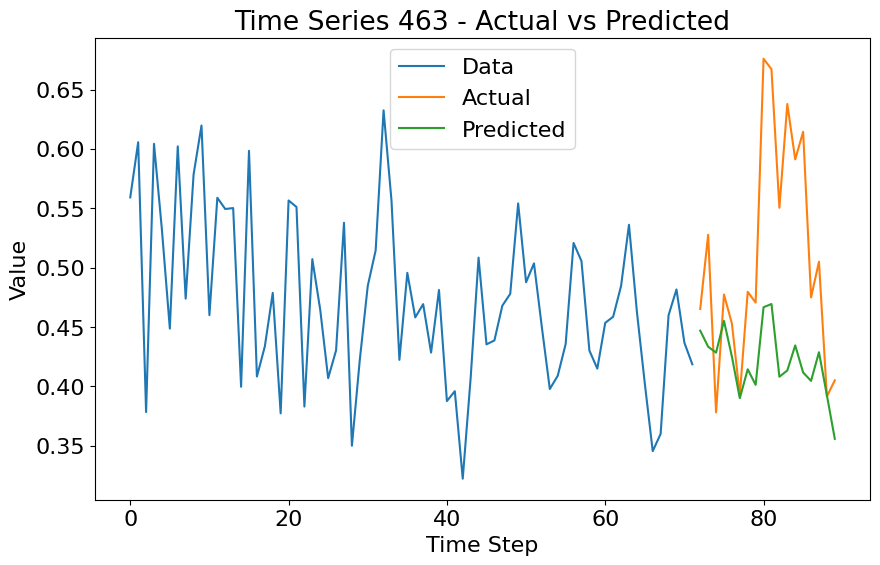

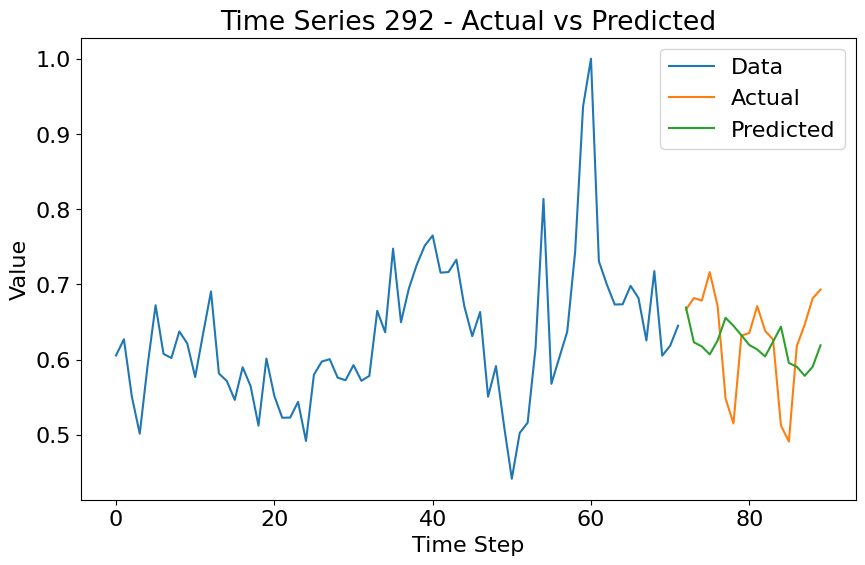

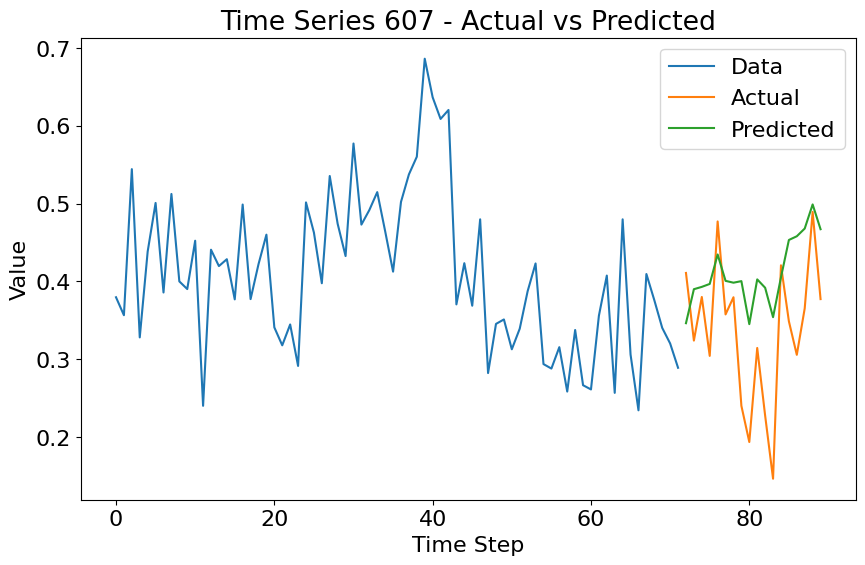

300/300 [==============================] - 3s 10ms/step - loss: 0.1092 - mean_absolute_error: 0.1092 - mean_squared_error: 0.0253


[0.10917305201292038, 0.10917305201292038, 0.025328999385237694]

In [69]:
# plot some images
import Utils
l = 1000
valid_data_predictions = model.predict(validation_data[:l])
for _ in range(10):
    idx = np.random.randint(0, l)
    Utils.plot_predictions(validation_data, valid_data_predictions, validation_labels, idx)

model.evaluate(test_data, test_labels)

In [70]:
model.save("model.h5")

## Optuna optimization

In [ ]:
import optuna as opt
from optuna.integration import TFKerasPruningCallback
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler

def objective(trial):
    # Clear clutter from previous session graphs.
    tf.keras.backend.clear_session()

    # Hyperparameters to be tuned by Optuna.
    trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    trial.suggest_int("num_layers", 1, 3)
    trial.suggest_int("num_units_lstm", 16, 128, log=True)
    trial.suggest_int("num_units_final_dense", 16, 128, log=True)
    trial.suggest_float("dropout", 0.0, 0.5)
    
    batch_size = 256
    epochs = 30

    # Build the model.
    model = build_LSTM_ENC_DEC_model_params(input_shape, output_shape, **trial.params)

    # Train the model.
    model.fit(
        x = train_data,
        y = train_labels,
        batch_size = batch_size,
        epochs = epochs,
        validation_data=(validation_data, validation_labels),
        callbacks = [
            tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', min_delta=0.0001, patience=3, restore_best_weights=True),
            tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=2, factor=0.1, min_lr=1e-5),
            TFKerasPruningCallback(trial, "val_loss"),
        ]
    )

    # Evaluate the model accuracy on the validation set.
    score = model.evaluate(validation_data, validation_labels, verbose=0)
    return score[0]

input_shape = train_data.shape[1:]
output_shape = train_labels.shape[1:]

# create a study object and optimize the objective function.
study = opt.create_study(direction="minimize", pruner=MedianPruner(n_warmup_steps=1), sampler=TPESampler(seed=seed), study_name='LSTM_ENC_DEC_model_params', storage='sqlite:///../data/optuna.db', load_if_exists=True)
study.optimize(objective, n_trials=100)

In [12]:
study.best_params

{'learning_rate': 0.002555085039485097,
 'num_layers': 2,
 'num_units_lstm': 28,
 'num_units_final_dense': 31,
 'dropout': 0.3218563683119118}

In [17]:
batch_size = 256
epochs = 10

model = build_LSTM_ENC_DEC_model_params(input_shape, output_shape, study.best_params)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True) 

Model: "Better_CONV_LSTM_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 200, 1)]             0         []                            
                                                                                                  
 lambda_3 (Lambda)           (None, 1, 1)                 0         ['input_layer[0][0]']         
                                                                                                  
 tf.math.subtract_3 (TFOpLa  (None, 200, 1)               0         ['input_layer[0][0]',         
 mbda)                                                               'lambda_3[0][0]']            
                                                                                                  
 bidirectional_6 (Bidirecti  (None, 200, 64)              8704      ['tf.math

In [20]:
# Train the model
history = model.fit(
    x = train_data,
    y = augmented_train_labels,
    batch_size = batch_size,
    epochs = epochs,
    # validation_data=(validation_data, validation_labels),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', min_delta=0.0003, patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=8, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/10
1688/1688 [==============================] - 41s 20ms/step - loss: 0.0231 - mean_absolute_error: 0.1097 - lr: 0.0010
Epoch 2/10
1688/1688 [==============================] - 34s 20ms/step - loss: 0.0204 - mean_absolute_error: 0.1019 - lr: 0.0010
Epoch 3/10
1688/1688 [==============================] - 35s 21ms/step - loss: 0.0196 - mean_absolute_error: 0.0995 - lr: 0.0010
Epoch 4/10
1688/1688 [==============================] - 35s 21ms/step - loss: 0.0191 - mean_absolute_error: 0.0981 - lr: 0.0010
Epoch 5/10
1688/1688 [==============================] - 35s 21ms/step - loss: 0.0186 - mean_absolute_error: 0.0967 - lr: 0.0010
Epoch 6/10
1688/1688 [==============================] - 35s 21ms/step - loss: 0.0182 - mean_absolute_error: 0.0955 - lr: 0.0010
Epoch 7/10
1688/1688 [==============================] - 35s 21ms/step - loss: 0.0177 - mean_absolute_error: 0.0943 - lr: 0.0010
Epoch 8/10
1688/1688 [==============================] - 35s 21ms/step - loss: 0.0174 - mean_absolute_err

In [18]:
from C2.notebooks import Utils
from importlib import reload
reload(Utils)
test_data_predictions = model.predict(test_data)
Utils.evaluate_model(test_data_predictions, test_labels)

300/300 [==============================] - 4s 7ms/step
MAE: 0.11244506225454622
MSE: 0.026357403430591904
RMSE: 0.16234963329367857


In [ ]:
# Evaluate random samples
Utils.evaluate_model(np.random.rand(*test_data_predictions.shape), test_labels)

In [ ]:
for _ in range(10):
    idx = np.random.randint(0, len(test_data))
    Utils.plot_predictions(test_data, test_data_predictions, test_labels,idx)
    # Utils.plot_predictions(train_data, test_data_predictions, train_labels,idx)

# Retraining for submission

In [3]:
input_folder = '../data/training_dataset/'
training_data = np.load(input_folder + 'training_data.npy')
valid_periods = np.load(input_folder + 'valid_periods.npy')
categories = np.load(input_folder + 'categories.npy')

dataset, labels = build_sequences_optimized(training_data, valid_periods)
train_data, train_labels = augment_data(dataset, labels)
train_data = train_data.reshape((train_data.shape[0], train_data.shape[1], 1))
train_labels = train_labels.reshape((train_labels.shape[0], train_labels.shape[1], 1))

input_shape = train_data.shape[1:]
output_shape = train_labels.shape[1:]
batch_size = 256
epochs = 10

params = {'learning_rate': 0.002555085039485097,
 'num_layers': 2,
 'num_units_lstm': 28,
 'num_units_final_dense': 31,
 'dropout': 0.3218563683119118}
model = build_LSTM_ENC_DEC_model_params(input_shape, output_shape, **params)

# Train the model
history = model.fit(
    x = train_data,
    y = train_labels,
    batch_size = batch_size,
    epochs = epochs,
).history

model.save('../data/models/LSTM_ENC_DEC_model_params.h5')

Dataset shape:  (48000, 200)
Augmentation round: 0
Augmentation round: 1
Augmentation round: 2
Epoch 1/10


I0000 00:00:1702686771.541976   81147 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1688/1688 [==============================] - 80s 44ms/step - loss: 0.0265 - mean_absolute_error: 0.1199
Epoch 2/10
1688/1688 [==============================] - 74s 44ms/step - loss: 0.0216 - mean_absolute_error: 0.1072
Epoch 3/10
1688/1688 [==============================] - 74s 44ms/step - loss: 0.0201 - mean_absolute_error: 0.1032
Epoch 4/10
1688/1688 [==============================] - 74s 44ms/step - loss: 0.0192 - mean_absolute_error: 0.1008
Epoch 5/10
1688/1688 [==============================] - 74s 44ms/step - loss: 0.0184 - mean_absolute_error: 0.0987
Epoch 6/10
1688/1688 [==============================] - 74s 44ms/step - loss: 0.0178 - mean_absolute_error: 0.0969
Epoch 7/10
1688/1688 [==============================] - 74s 44ms/step - loss: 0.0173 - mean_absolute_error: 0.0957
Epoch 8/10
1688/1688 [==============================] - 75s 44ms/step - loss: 0.0169 - mean_absolute_error: 0.0946
Epoch 9/10
1688/1688 [==============================] - 74s 44ms/step - loss: 0.0166 - mean

32/32 [==============================] - 0s 13ms/step


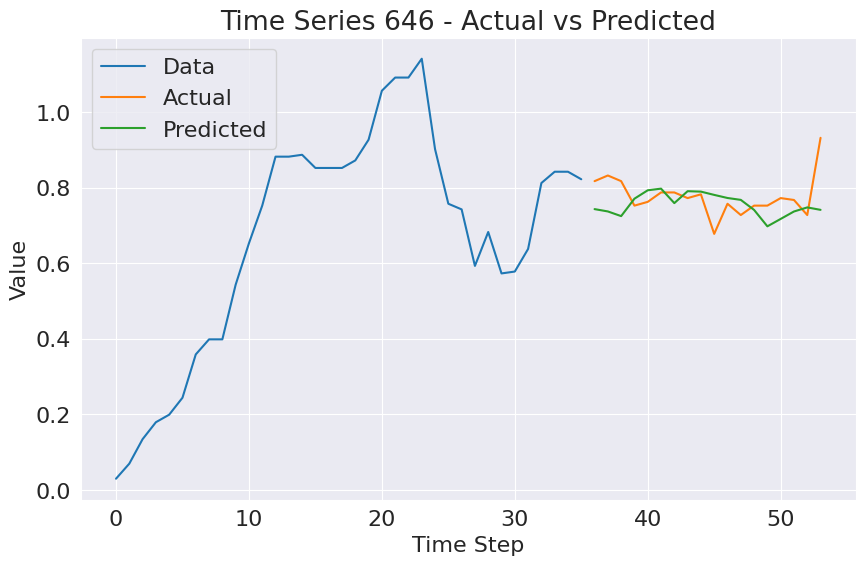

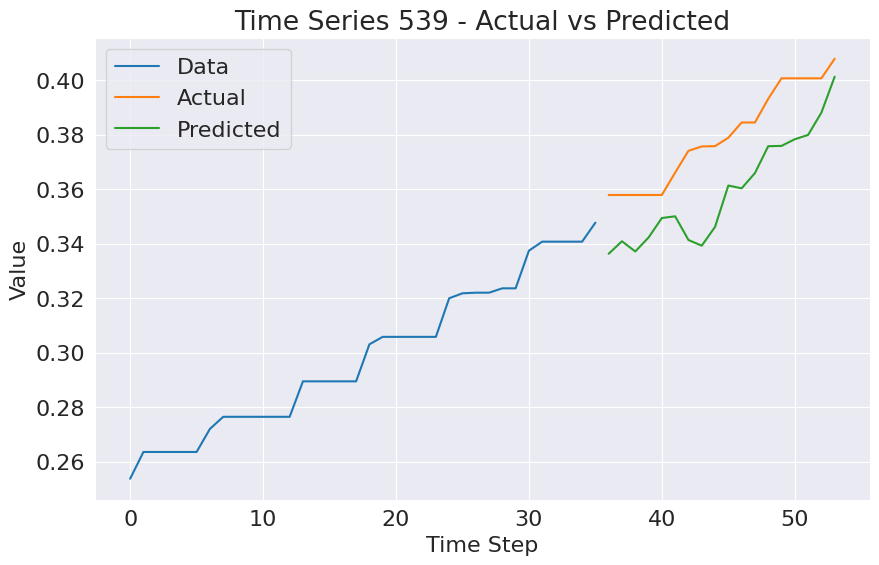

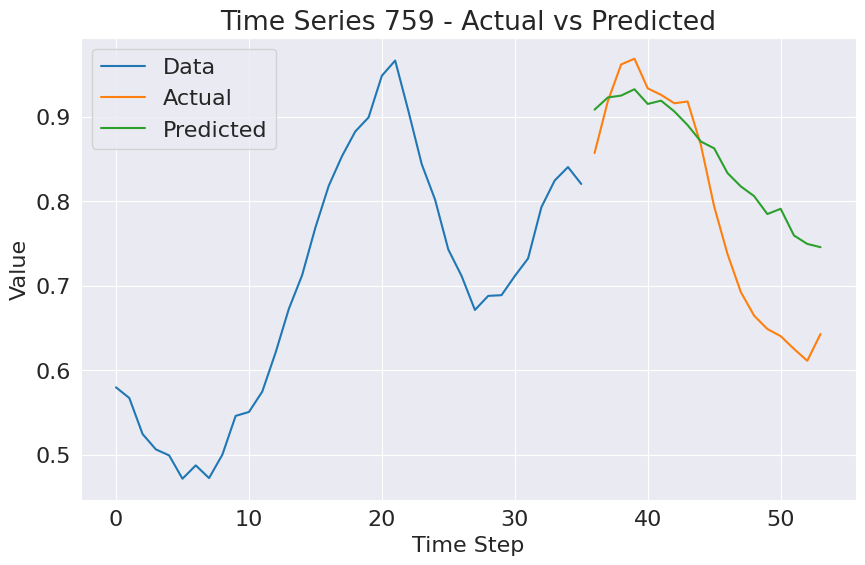

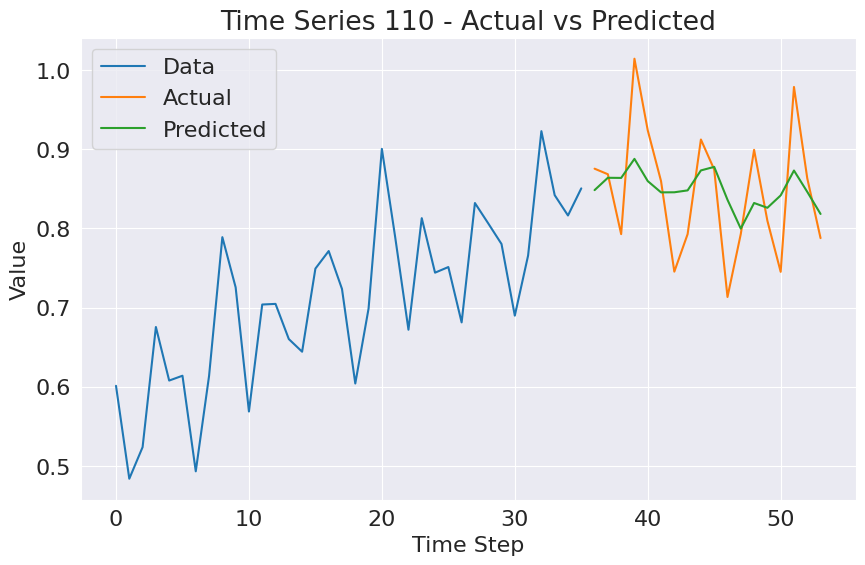

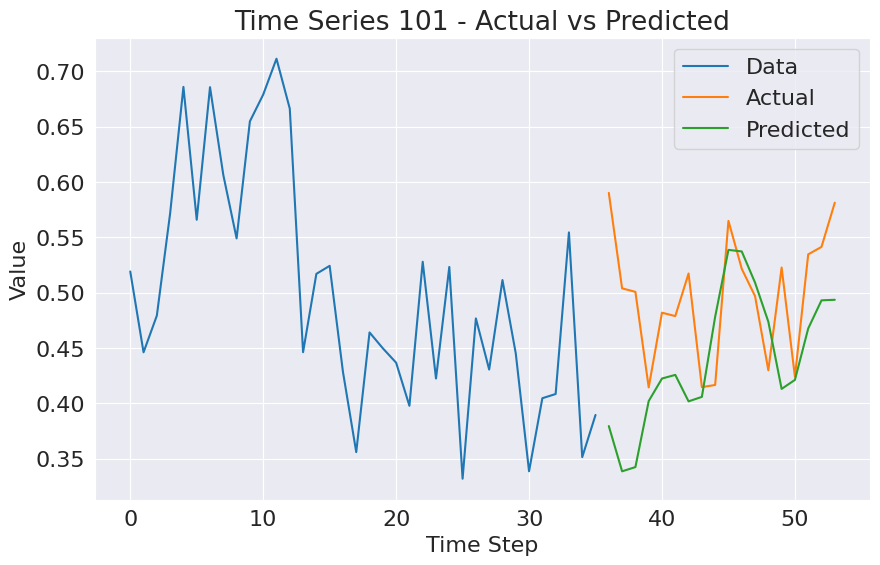

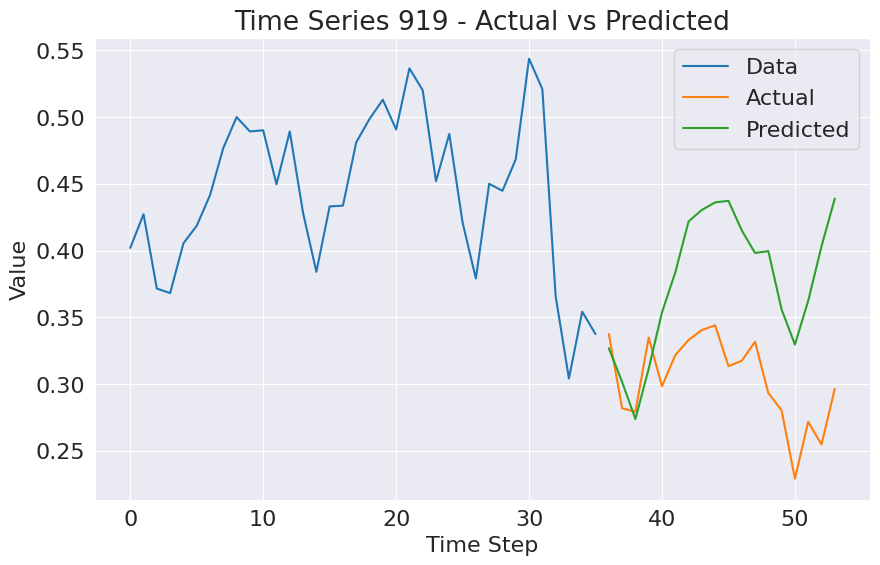

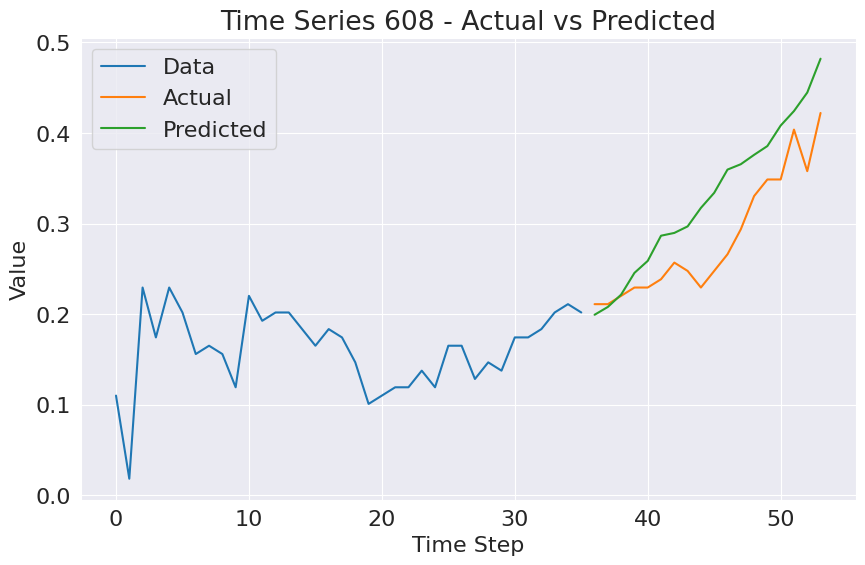

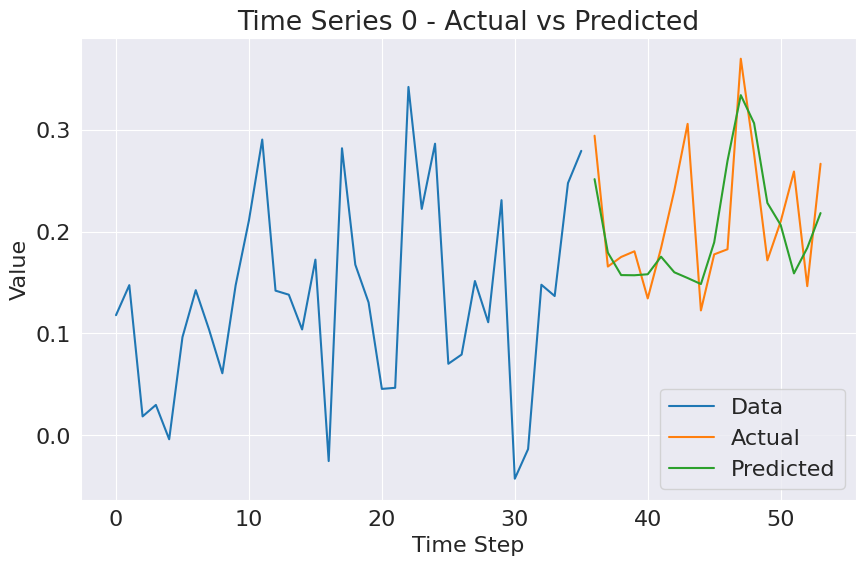

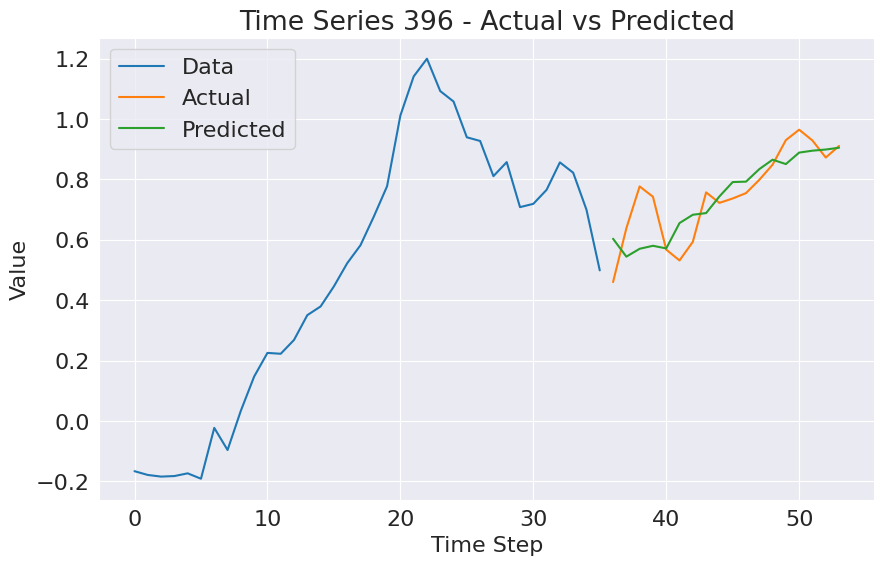

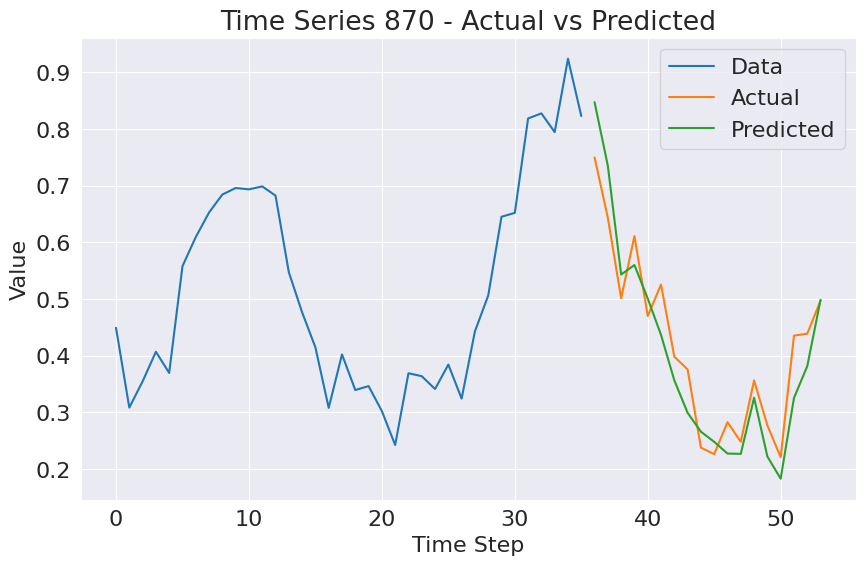

In [6]:
# plot some images
import Utils
l = 1000
valid_data_predictions = model.predict(train_data[:l])
for _ in range(10):
    idx = np.random.randint(0, l)
    Utils.plot_predictions(train_data, valid_data_predictions, train_labels, idx)